# Practical example: Using a Multi-Layer Perceptron to retrieve precipitation

- The previous section introduced the basics of neural network and how to implement them using PyTorch
- This is sufficient to design your first precipitation retrieval

## Motivation

 - Satllite observations allow us to observe the global distribution of precipitation
 - However, there is no direct relationship between the satellite observations and the corresponding precipitation at the surface

## The data
 - We will use the Precipitation Retrieval Benchmark (PRB) dataset developed by the International Precipitation Working Group
 - The dataset consists of satellite data collocated with precipitation estimates from ground-based radars

In [1]:
%load_ext autoreload
%autoreload 2
    
import ipwgml
from ipwgml.data import download_dataset

files = download_dataset("spr", "gmi", "gmi", "validation", "on_swath", "tabular")


In [2]:
import hdf5plugin

In [3]:
import xarray as xr
input_data = xr.load_dataset(files["gmi"][0], engine="h5netcdf")
target_data = xr.load_dataset(files["target"][0], engine="h5netcdf")

In [4]:
input_data

<xarray.Dataset> Size: 2GB
Dimensions:                (samples: 9998961, channel: 13)
Dimensions without coordinates: samples, channel
Data variables:
    observations           (samples, channel) float64 1GB 277.7 266.7 ... 258.4
    earth_incidence_angle  (samples, channel) float64 1GB 52.75 52.75 ... 49.15

In [5]:
target_data

<xarray.Dataset> Size: 720MB
Dimensions:              (samples: 9998961)
Dimensions without coordinates: samples
Data variables:
    time                 (samples) datetime64[ns] 80MB 2020-01-01T01:04:00 .....
    surface_precip       (samples) float64 80MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    radar_quality_index  (samples) float64 80MB 0.0 0.0 0.0 ... 0.06693 0.0 0.0
    valid_fraction       (samples) float64 80MB 0.8465 0.9724 ... 1.0 0.9606
    precip_fraction      (samples) float64 80MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    snow_fraction        (samples) float64 80MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    hail_fraction        (samples) float64 80MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    convective_fraction  (samples) float64 80MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    stratiform_fraction  (samples) float64 80MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [6]:
valid_samples = target_data.radar_quality_index > 0.8
input_data = input_data[{"samples": valid_samples}]
target_data = target_data[{"samples": valid_samples}]

## EDA

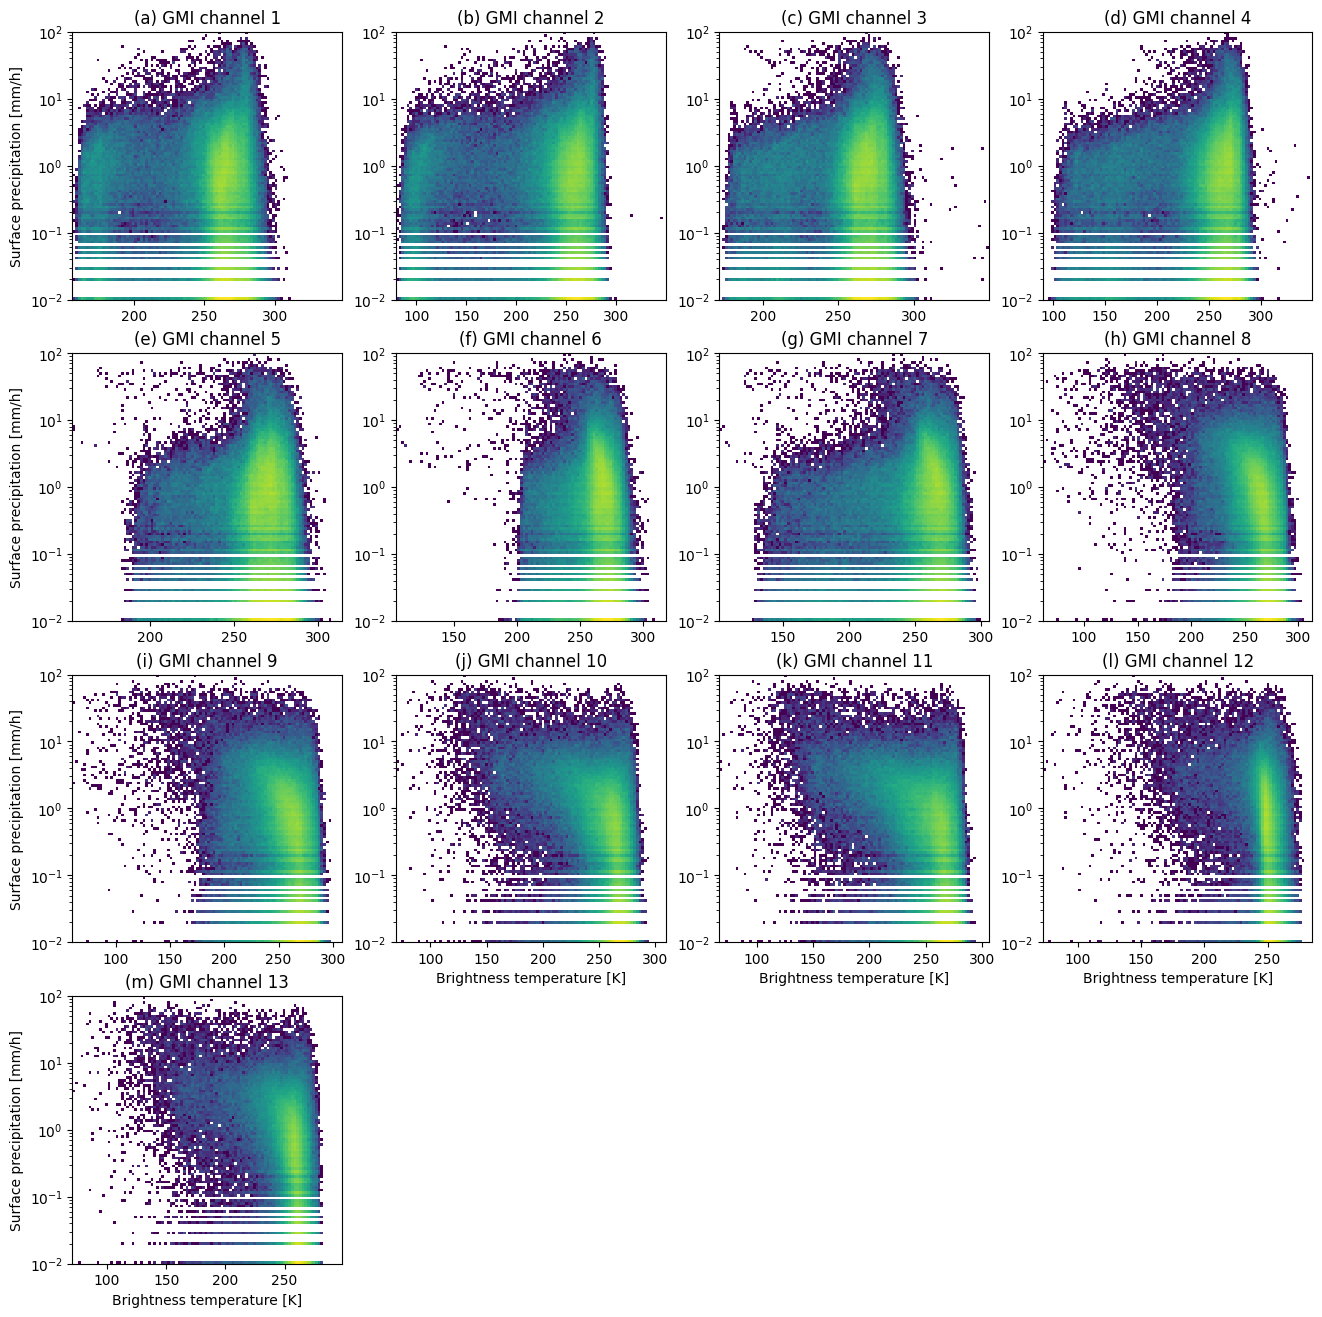

In [7]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
import numpy as np

n_rows = 4
n_cols = 4
fig = plt.figure(figsize=(4 * n_rows, 4 * n_cols))
gs = GridSpec(n_rows, n_cols)

surface_precip = target_data["surface_precip"].data
surface_precip_bins = np.logspace(-2, 2, 101)

for row_ind in range(4):
    for col_ind in range(4):
        channel_ind = row_ind * 4 + col_ind
        
        if channel_ind > 12:
            continue
        
        ax = fig.add_subplot(gs[row_ind, col_ind])
        obs = input_data["observations"][{"channel": channel_ind}]
        obs_bins = np.linspace(obs.min(), obs.max(), 101)
        cts = np.histogram2d(obs, surface_precip, bins=(obs_bins, surface_precip_bins))[0]

        ax.pcolormesh(obs_bins, surface_precip_bins, cts.T, norm=LogNorm())
        ax.set_yscale("log")

        ax.set_title(f"({chr(ord('a') + channel_ind)}) GMI channel {channel_ind + 1}")

        if col_ind == 0:
            ax.set_ylabel("Surface precipitation [mm/h]")

        if channel_ind > 8:
            ax.set_xlabel("Brightness temperature [K]")
        

In [8]:
import torch 

obs_min = input_data.observations.min("samples")
obs_max = input_data.observations.max("samples")

obs_n = -1.0  + (input_data.observations - obs_min) / (obs_max - obs_min)
obs = torch.tensor(obs_n.data).to(torch.float32)
obs = torch.nan_to_num(obs, nan=-1.5)

obs = torch.tensor(obs.data).to(torch.float32)
surface_precip = torch.tensor(target_data.surface_precip.data).to(torch.float32)

/tmp/ipykernel_1676206/2589277915.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs.data).to(torch.float32)


In [9]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(obs, surface_precip)
data_loader = DataLoader(dataset, num_workers=4, batch_size=1024, shuffle=True)

In [11]:
from torch import nn

mlp = nn.Sequential(
    nn.Linear(13, 128),
    nn.GELU(),
    nn.Linear(128, 128),
    nn.GELU(),
    nn.Linear(128, 128),
    nn.GELU(),
    nn.Linear(128, 1)
)

In [12]:
from tqdm import tqdm
from torch.optim import SGD

loss_fn = nn.MSELoss()
optimizer = SGD(mlp.parameters(), lr=5e-2)

n_epochs = 100

for epoch_index in range(n_epochs):

    tot_loss = 0.0
    n_samples = 0
    
    for x_b, y_b in tqdm(data_loader):
        
        loss = loss_fn(y_b[..., None], mlp(x_b))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        tot_loss += loss.item()
        n_samples += y_b.numel()

    print(f"Epoch {epoch_index}, Avg. loss: {tot_loss / n_samples}")


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:21<00:00, 149.51it/s]


Epoch 0, Avg. loss: 0.0009018311409033326


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:19<00:00, 163.44it/s]


Epoch 1, Avg. loss: 0.0007869047669942669


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:19<00:00, 166.42it/s]


Epoch 2, Avg. loss: 0.0007236533953278478


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:16<00:00, 194.92it/s]


Epoch 3, Avg. loss: 0.0006908614623056582


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:21<00:00, 148.26it/s]


Epoch 4, Avg. loss: 0.0006704378800362919


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:17<00:00, 180.25it/s]


Epoch 5, Avg. loss: 0.000656782879374453


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:18<00:00, 171.84it/s]


Epoch 6, Avg. loss: 0.0006443028849867693


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:16<00:00, 198.02it/s]


Epoch 7, Avg. loss: 0.0006331605728587774


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:18<00:00, 175.45it/s]


Epoch 8, Avg. loss: 0.0006230117044698258


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:19<00:00, 160.89it/s]


Epoch 9, Avg. loss: 0.0006248316193298266


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:18<00:00, 169.08it/s]


Epoch 10, Avg. loss: 0.000606728475567916


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:18<00:00, 168.39it/s]


Epoch 11, Avg. loss: 0.0005993332780368638


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:20<00:00, 158.61it/s]


Epoch 12, Avg. loss: 0.0005946370309117752


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:19<00:00, 166.16it/s]


Epoch 13, Avg. loss: 0.0005892879442947826


100%|██████████████████████████████████████████████████████████████| 3183/3183 [00:19<00:00, 165.15it/s]


Epoch 14, Avg. loss: 0.0005817047774301719


 19%|████████████▏                                                   | 606/3183 [00:05<00:44, 57.67it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f35edb69710>>
Traceback (most recent call last):
  File "/home/simon/miniconda3/envs/at652/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
 20%|████████████▎                                                  | 624/3183 [00:05<00:23, 109.89it/s]


KeyboardInterrupt: 

## Results

In [13]:
from ipwgml.evaluation import Evaluator
                            
evaluator = Evaluator(
    reference_sensor="gmi",
    geometry="on_swath",
    retrieval_input=["gmi"],
)

In [27]:
def run_retrieval(input_data):

    input_data = input_data.transpose("batch", "channels_gmi")

    obs = input_data.obs_gmi.data
    obs_n = -1.0 +(obs - obs_min.data) / (obs_max.data - obs_min.data)
    obs = torch.nan_to_num(torch.tensor(obs_n).to(torch.float32), nan=-1.5)

    with torch.no_grad():
        surface_precip = mlp(obs)


    return xr.Dataset({
        "surface_precip": (("samples",), surface_precip[..., 0])
    })

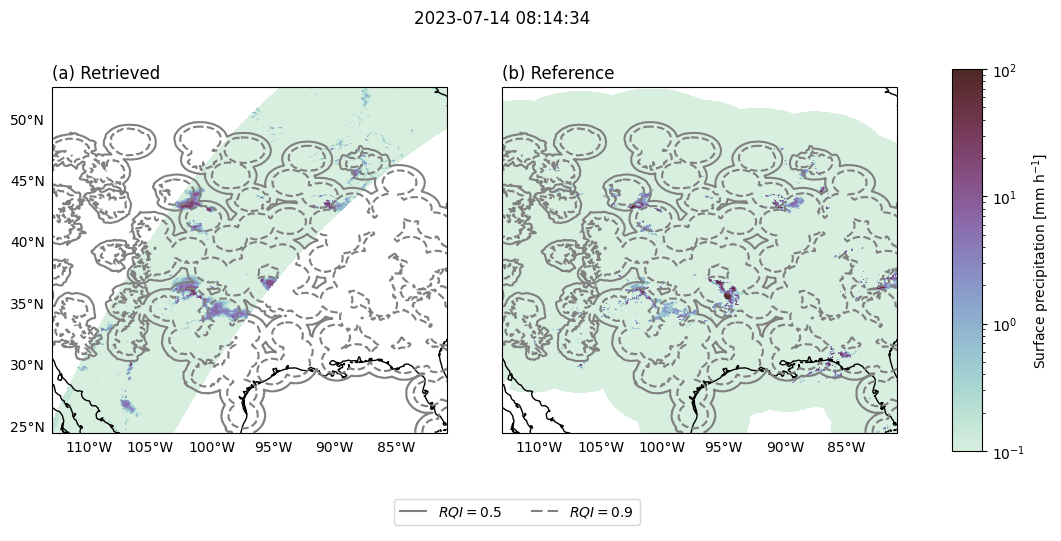

In [30]:
evaluator.plot_retrieval_results(87, run_retrieval, input_data_format="tabular", batch_size=1024);

### Retrieval metrics

In [32]:
evaluator.evaluate(
    retrieval_fn=run_retrieval, 
    input_data_format="tabular",
)

Output()

In [35]:
evaluator.get_results()

/home/simon/src/ipwgml/src/ipwgml/metrics.py:665: RuntimeWarning: divide by zero encountered in divide
  scales = 0.5 * (N - 1) * self.scale / n
/home/simon/src/ipwgml/src/ipwgml/metrics.py:823: RuntimeWarning: invalid value encountered in divide
  pod = self.n_true_positive / self.n_true
/home/simon/src/ipwgml/src/ipwgml/metrics.py:775: RuntimeWarning: invalid value encountered in divide
  far = self.n_false_positive / self.n_positive
/home/simon/src/ipwgml/src/ipwgml/metrics.py:876: RuntimeWarning: invalid value encountered in divide
  standard = n_pos / n_tot * n_true / n_tot + n_neg / n_tot * n_false / n_tot
/home/simon/src/ipwgml/src/ipwgml/metrics.py:877: RuntimeWarning: invalid value encountered in divide
  hss = ((self.n_tp + self.n_tn) / n_tot - standard) / (1.0 - standard)
/home/simon/src/ipwgml/src/ipwgml/metrics.py:954: RuntimeWarning: invalid value encountered in divide
  precision = self.n_tp / (self.n_tp + self.n_fp)
/home/simon/src/ipwgml/src/ipwgml/metrics.py:955: Runt

<xarray.Dataset> Size: 5kB
Dimensions:                 (scales: 16, threshold: 100, threshold_heavy: 100)
Coordinates:
  * scales                  (scales) float64 128B inf 0.558 ... 0.03986 0.0372
  * threshold               (threshold) float64 800B 0.0 0.0101 ... 0.9899 1.0
  * threshold_heavy         (threshold_heavy) float64 800B 0.0 0.0101 ... 1.0
Data variables: (12/19)
    bias                    float64 8B -3.885
    mae                     float64 8B 0.138
    mse                     float64 8B 1.646
    smape                   float64 8B 102.4
    correlation_coef        float64 8B 0.571
    spectral_coherence      (scales) float64 128B 0.9005 0.7217 ... 0.2219
    ...                      ...
    pod_heavy               float64 8B nan
    far_heavy               float64 8B nan
    hss_heavy               float64 8B nan
    precision_heavy         (threshold_heavy) float64 800B nan nan ... nan nan
    recall_heavy            (threshold_heavy) float64 800B nan nan ... nan nan
    area_under_curve_heavy  float64 8B 0.0

/home/simon/src/ipwgml/src/ipwgml/metrics.py:665: RuntimeWarning: divide by zero encountered in divide
  scales = 0.5 * (N - 1) * self.scale / n


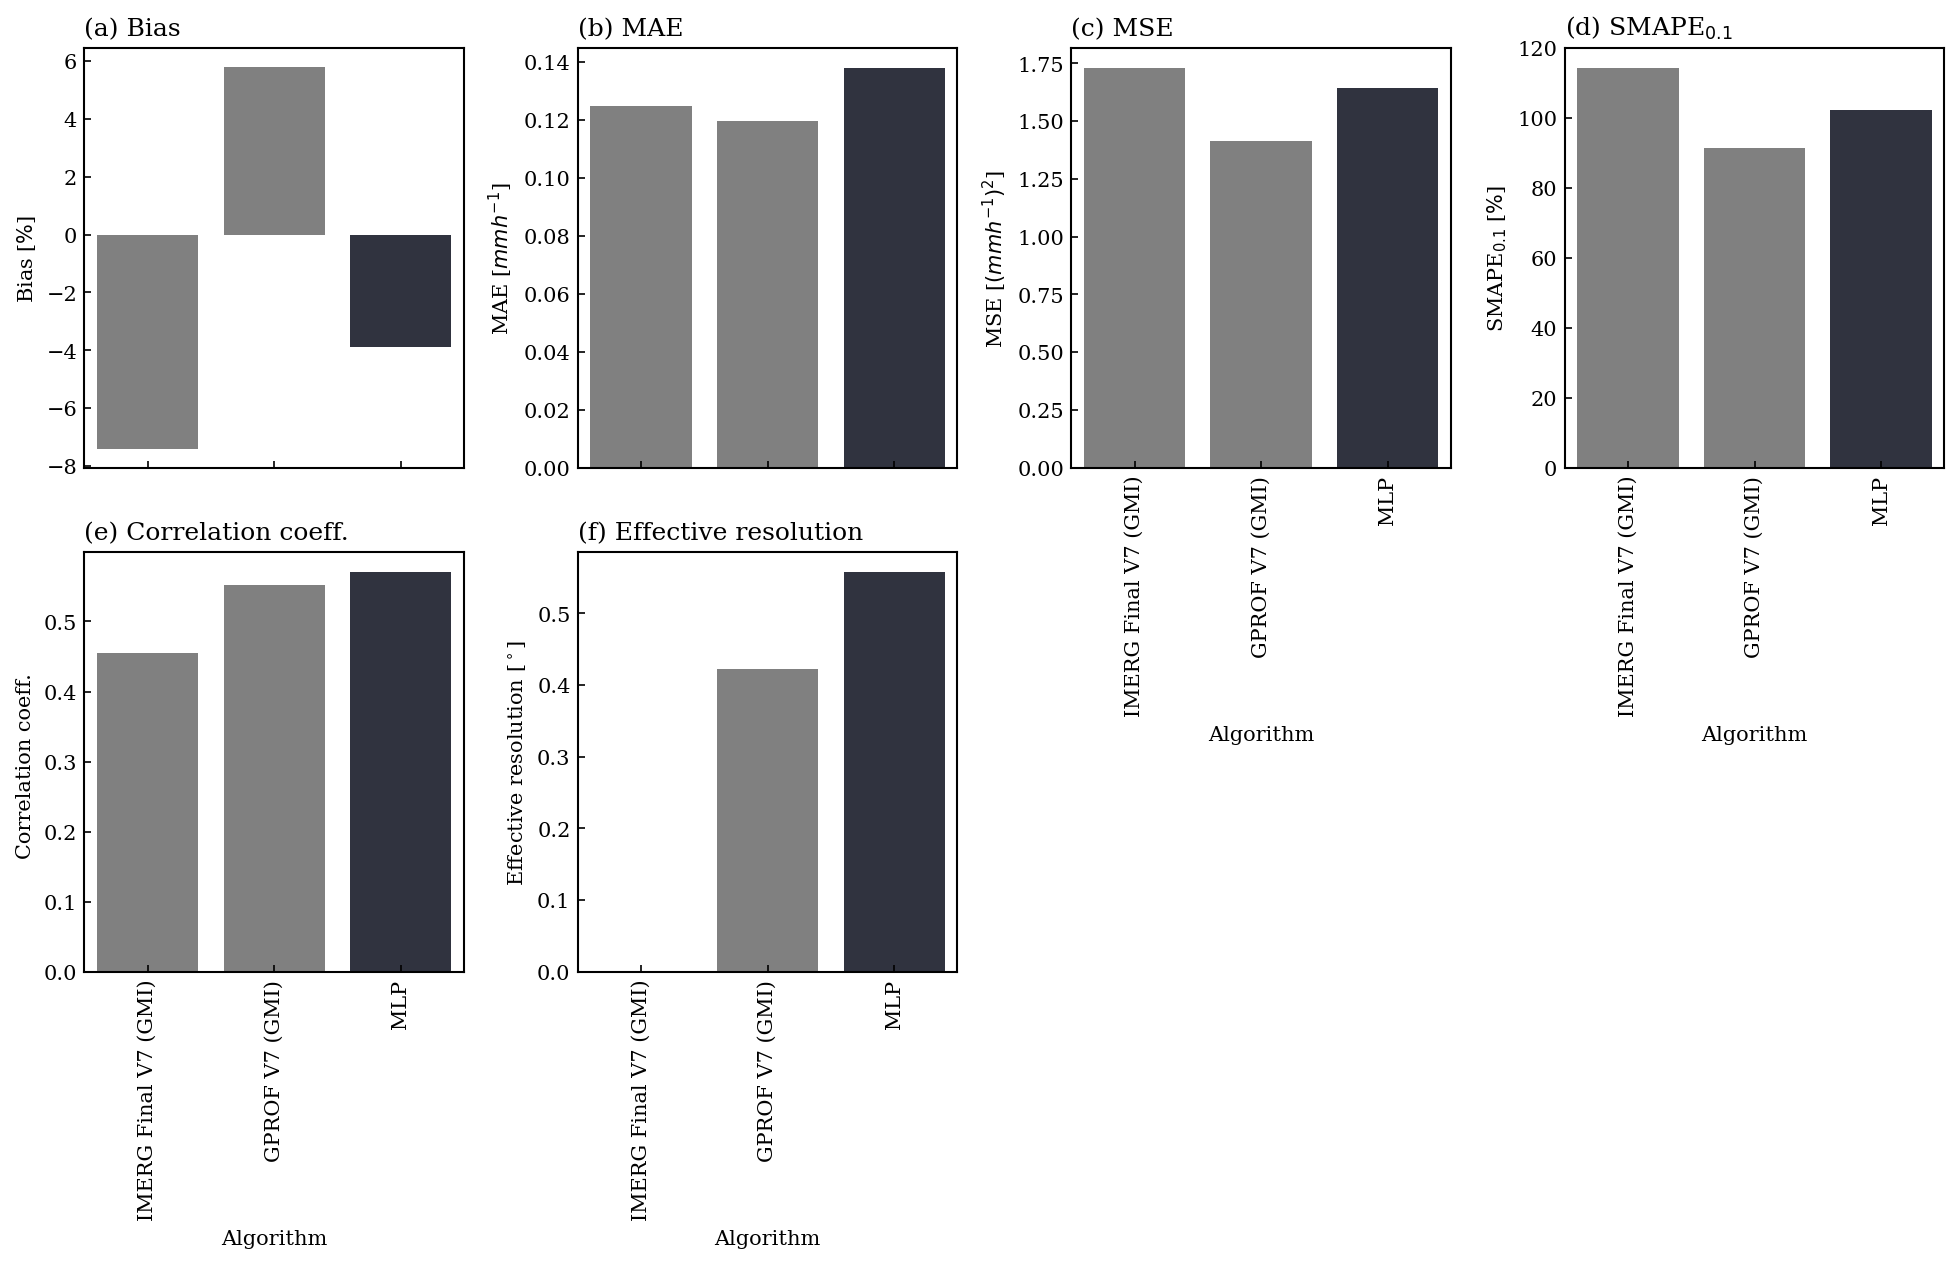

In [34]:
evaluator.plot_precip_quantification_results(name="MLP")